# Imports

Importons dans un premier temps l'ensemble des librairies qui vont nous servir durant l'entièreté de ce Notebook :

In [1]:
# builtin
import os
# datetime 
import datetime as dt

#data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#feature engineering
from sklearn.feature_selection import mutual_info_regression

#Afficher toutes le colonnes du data frame : 
pd.set_option('display.max_columns', 80)
pd.set_option("display.max_row", 80)

sns.set(style='whitegrid', palette='muted', color_codes=True)
print('OK!! ')

OK!! 


In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn import decomposition
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score



In [3]:
from functools import reduce
from dateutil.relativedelta import relativedelta
from sklearn.metrics import adjusted_rand_score

In [4]:
liste_data_cleaned = os.listdir("data/cleaned") 

In [5]:
liste_data_cleaned

['cleaned_customers_orders_payments_dataset.csv',
 'cleaned_merged_customer_dataset.csv',
 'cleaned_rfm_dataset.csv']

In [6]:
# Récupération des noms de datasets
# initializing substrings
sub1 = ""
sub2 = "_dataset.csv"
idx1 = 0
idx2 = 0
liste_name = []
for name in liste_data_cleaned:
    # getting index of substrings
    name = str(name)
    idx1 = name.index(sub1)
    idx2 = name.index(sub2)
    res = ''
    for idx in range(idx1 + len(sub1) , idx2):
        res = res + name[idx]
    #printing result
    name_= str(res)
    liste_name.append(name_)

In [7]:
liste_name

['cleaned_customers_orders_payments', 'cleaned_merged_customer', 'cleaned_rfm']

In [8]:
path = "./data/cleaned/"
for i, name in enumerate(liste_name):
    exec(f"{name} = pd.read_csv(path + liste_data_cleaned[i])")

In [9]:
cleaned_merged_customer

,customer_unique_id,recency,frequency,monetary,average_price,average_freight,payment_installments,quantity_of_items,mean_reviews_scores,mean_days_delivery,catg_construction,catg_electronics,catg_fashion,catg_furniture,catg_home,catg_others,catg_sports_leisure
0,0000366f3b9a7992bf8c76cfdf3221e2,236,1,141.90,129.90,12.00,8.0,1,5.0,6.0,0,0,0,1,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,239,1,27.19,18.90,8.29,1.0,1,4.0,3.0,0,0,1,0,0,0,0
2,0000f46a3911fa3c0805444483337064,662,1,86.22,69.00,17.22,8.0,1,3.0,25.0,0,0,0,0,0,1,0
3,0000f6ccb0745a6a4b88665a16c9f078,446,1,43.62,25.99,17.63,4.0,1,4.0,20.0,0,1,0,0,0,0,0
4,0004aac84e0df4da2b147fca70cf8255,413,1,196.89,180.00,16.89,6.0,1,5.0,13.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95415,fffcf5a5ff07b0908bd4e2dbc735a684,572,2,2067.42,785.00,248.71,10.0,2,5.0,27.0,0,0,2,0,0,0,0
95416,fffea47cd6d3cc0a88bd621562a9d061,387,1,84.58,64.89,19.69,1.0,1,4.0,30.0,0,0,0,0,0,1,0
95417,ffff371b4d645b6ecea244b27531430a,693,1,112.46,89.90,22.56,1.0,1,5.0,14.0,0,0,0,0,0,1,0
95418,ffff5962728ec6157033ef9805bacc48,244,1,133.69,115.00,18.69,5.0,1,5.0,11.0,0,0,1,0,0,0,0


In [10]:
cleaned_customers_orders_payments["order_purchase_timestamp"].max()

'2018-09-03 09:06:57'

# Simulation

In [11]:
import datetime as dt

def calculate_recency(df, col_date, id_, ref_date):  
    
    df_ = df.copy()
    df_[col_date] = pd.to_datetime(df_[col_date])
        

    recency_df = df_.groupby(id_)[col_date].max().reset_index()
    
    recency_df[col_date] = recency_df[col_date].apply(lambda x: x.strftime('%Y-%m-%d'))
    recency_df[col_date] = pd.to_datetime(recency_df[col_date])
    

    recency_df['recency'] = (ref_date - recency_df[col_date]).dt.days

    recency_df.drop(col_date, axis=1, inplace=True)


    recency_df.columns = [id_, 'recency']
    
    return recency_df

Nous allons à présent calculer calcuer les trois variables R,F,M, pour ce faire nous allons prendre en compte la connexion du clients usr le site, car selon le nombre d'article d'une commande, on peut avoir des lignes qui se répètent : 

In [12]:
def calculate_frequency(df, id_):
    df_=df.copy()
    
    frequency_df = df_[id_].value_counts().reset_index()
    frequency_df.columns = [id_, 'frequency']
    return frequency_df

In [13]:
def calculate_monetary(df, id_, price_col):
    df_= df.copy()
    monetary_df = df_.groupby(id_)[price_col].sum().reset_index()
    monetary_df.columns = [id_, 'monetary']
    return monetary_df

In [14]:
def reviews_score(df):
    df_= df.copy()
    df_ = df.groupby('customer_unique_id')['review_score'].mean().reset_index()
    df_.columns = ['customer_unique_id', 'mean_reviews_scores']
    return df_

In [15]:
def save_transformed_df(df, path, filename, columns_to_save):
    df[columns_to_save].to_csv(path + filename, index=False)

In [16]:
def kmeans_clustering(data, n_clusters):
    # Scale data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    # k-means clustering
    kmeans = KMeans(n_clusters= n_clusters, max_iter= 300, n_init= 10,init= 'k-means++', algorithm= 'auto' , random_state=0)
    kmeans.fit(data_scaled)
    
    # cluster labels
    cluster_labels = kmeans.labels_
    
    return cluster_labels

In [17]:
def df_generator_k_means(customer_df=None, col_date=None, datetime_refs=None, id_=None, price_col=None, n_clusters=0):
    
    #Initialisation du df à retourner
    df = pd.DataFrame()
    
    #Boucle sur les dates de références
    for ref in datetime_refs:
        
        #Copie du data frame clients
        df_ = customer_df.copy()
        
        # Vérification du typage de  la colonne col_date 
        df_[col_date] = pd.to_datetime(df_[col_date])
        
        #Séléction des lignes 
        df_ = df_[df_[col_date] < ref]
        
        # Recency : 
        recency_df = calculate_recency(df_, col_date, id_, ref)
        
        # Frequency : 
        frequecy_df = calculate_frequency(df_, id_)
        
        # Monetary : 
        monetary_df = calculate_monetary(df_, id_, price_col)
        
        # Mean reviews scores : 
        reviews_score_df = reviews_score(cleaned_customers_orders_payments)
        
        # liste des df à merge
        dfs_to_merge = [recency_df, frequecy_df, monetary_df, reviews_score_df]

        # merge 
        rfm_df = reduce(lambda left, right: pd.merge(left, right, on=id_), dfs_to_merge)
        
        rfm_df['datetime_ref'] = ref
        
        #Set Index : 
        rfm_df = rfm_df.set_index(id_)
        
        # k-means : 
        var_to_scale = list(rfm_df)[:-1]
        df_to_cluster = rfm_df[var_to_scale]
        clusters = kmeans_clustering(df_to_cluster, n_clusters)
        
       
        
        rfm_df['cluster'] = clusters
        df = pd.concat([df, rfm_df])
                
#         # Increase datetime_ref by one week
#         ref += relativedelta(days=1)
        
    df = df.reset_index()
   
    return df


# Simulation par 1 semaine

In [18]:
col_date = 'order_purchase_timestamp'
id_ = 'customer_unique_id'
price_col = 'payment_value'

# Dates de ref pour le cal
start_date = dt.datetime(2017, 12,31)
end_date = dt.datetime(2018, 9, 10)
datetime_refs = [start_date]

while datetime_refs[-1] < end_date:
    datetime_refs.append(datetime_refs[-1] + relativedelta(weeks=1))

df = df_generator_k_means(customer_df=cleaned_customers_orders_payments, 
                         col_date=col_date, 
                         datetime_refs=datetime_refs, 
                         id_=id_, 
                         price_col=price_col,
                        n_clusters = 5)




In [19]:
datetime_refs

[datetime.datetime(2017, 12, 31, 0, 0),
 datetime.datetime(2018, 1, 7, 0, 0),
 datetime.datetime(2018, 1, 14, 0, 0),
 datetime.datetime(2018, 1, 21, 0, 0),
 datetime.datetime(2018, 1, 28, 0, 0),
 datetime.datetime(2018, 2, 4, 0, 0),
 datetime.datetime(2018, 2, 11, 0, 0),
 datetime.datetime(2018, 2, 18, 0, 0),
 datetime.datetime(2018, 2, 25, 0, 0),
 datetime.datetime(2018, 3, 4, 0, 0),
 datetime.datetime(2018, 3, 11, 0, 0),
 datetime.datetime(2018, 3, 18, 0, 0),
 datetime.datetime(2018, 3, 25, 0, 0),
 datetime.datetime(2018, 4, 1, 0, 0),
 datetime.datetime(2018, 4, 8, 0, 0),
 datetime.datetime(2018, 4, 15, 0, 0),
 datetime.datetime(2018, 4, 22, 0, 0),
 datetime.datetime(2018, 4, 29, 0, 0),
 datetime.datetime(2018, 5, 6, 0, 0),
 datetime.datetime(2018, 5, 13, 0, 0),
 datetime.datetime(2018, 5, 20, 0, 0),
 datetime.datetime(2018, 5, 27, 0, 0),
 datetime.datetime(2018, 6, 3, 0, 0),
 datetime.datetime(2018, 6, 10, 0, 0),
 datetime.datetime(2018, 6, 17, 0, 0),
 datetime.datetime(2018, 6, 24,

In [20]:
df.head()

,customer_unique_id,recency,frequency,monetary,mean_reviews_scores,datetime_ref,cluster
0,0000f46a3911fa3c0805444483337064,296,1,86.22,3.0,2017-12-31,1
1,0000f6ccb0745a6a4b88665a16c9f078,80,1,43.62,4.0,2017-12-31,2
2,0004aac84e0df4da2b147fca70cf8255,47,1,196.89,5.0,2017-12-31,2
3,0005e1862207bf6ccc02e4228effd9a0,302,1,150.12,4.0,2017-12-31,1
4,0006fdc98a402fceb4eb0ee528f6a8d4,166,1,29.00,3.0,2017-12-31,0


In [21]:
df['datetime_ref'].unique()

array(['2017-12-31T00:00:00.000000000', '2018-01-07T00:00:00.000000000',
       '2018-01-14T00:00:00.000000000', '2018-01-21T00:00:00.000000000',
       '2018-01-28T00:00:00.000000000', '2018-02-04T00:00:00.000000000',
       '2018-02-11T00:00:00.000000000', '2018-02-18T00:00:00.000000000',
       '2018-02-25T00:00:00.000000000', '2018-03-04T00:00:00.000000000',
       '2018-03-11T00:00:00.000000000', '2018-03-18T00:00:00.000000000',
       '2018-03-25T00:00:00.000000000', '2018-04-01T00:00:00.000000000',
       '2018-04-08T00:00:00.000000000', '2018-04-15T00:00:00.000000000',
       '2018-04-22T00:00:00.000000000', '2018-04-29T00:00:00.000000000',
       '2018-05-06T00:00:00.000000000', '2018-05-13T00:00:00.000000000',
       '2018-05-20T00:00:00.000000000', '2018-05-27T00:00:00.000000000',
       '2018-06-03T00:00:00.000000000', '2018-06-10T00:00:00.000000000',
       '2018-06-17T00:00:00.000000000', '2018-06-24T00:00:00.000000000',
       '2018-07-01T00:00:00.000000000', '2018-07-08

In [22]:
# transformed_geolocation_dataset
path = "./data/simulation/"
filename = "simulation_segments_per_one_week.csv"
columns_to_save = list(df.columns)

# Save
save_transformed_df(df, path, filename, columns_to_save)

In [23]:
df.shape

(2723530, 7)

In [24]:
df["datetime_ref"] = pd.to_datetime(df["datetime_ref"])

In [25]:
df['cluster'].unique()

array([1, 2, 0, 4, 3])

In [26]:
start_date

datetime.datetime(2017, 12, 31, 0, 0)

In [27]:
msk = df['frequency'] > 1
test = df[msk]

In [28]:
test

,customer_unique_id,recency,frequency,monetary,mean_reviews_scores,datetime_ref,cluster
9,000de6019bb59f34c099a907c151d855,136,2,514.88,2.0,2017-12-31,0
11,001147e649a7b1afd577e873841632dd,122,2,424.32,4.0,2017-12-31,2
18,001926cef41060fae572e2e7b30bd2a4,136,2,182.42,4.0,2017-12-31,2
25,00293787e2aec37a9c253b63fdfe2049,65,2,515.74,3.0,2017-12-31,0
27,002ae492472e45ad6ebeb7a625409392,84,2,437.32,3.0,2017-12-31,0
...,...,...,...,...,...,...,...
2723497,ffe96201d466b0e0dc8139850be29d5d,62,2,192.84,5.0,2018-09-16,1
2723513,fff22793223fe80c97a8fd02ac5c6295,82,3,267.57,5.0,2018-09-16,2
2723517,fff5eb4918b2bf4b2da476788d42051c,76,6,17069.76,5.0,2018-09-16,4
2723519,fff7219c86179ca6441b8f37823ba3d3,263,2,531.60,4.0,2018-09-16,1


In [29]:
test = test.set_index('customer_unique_id')

In [30]:
range(len(datetime_refs)-1)

range(0, 37)

In [31]:
msk  = test['datetime_ref'] == start_date
initial_kmeans_df = test[msk]

In [32]:
initial_labels = initial_kmeans_df['cluster'].values

In [33]:

ARI_scores = []
date_de_ref = []
nombre_week = []

for i in range(len(datetime_refs)-1):
    date_ref_suivante = datetime_refs[i]
    ref_df2 = test[test['datetime_ref'] == date_ref_suivante]
    ref_df2 = ref_df2[ref_df2.index.isin(initial_kmeans_df.index)]
    predicted_labels = ref_df2['cluster'].values
    
    ARI_scores.append(adjusted_rand_score(initial_labels, predicted_labels))
    date_de_ref.append(date_ref_suivante)
    numb_week = (datetime_refs[i] - start_date).days
    nombre_week.append(numb_week)
    
df_recap_ = pd.DataFrame({
    "Date_Ref":date_de_ref,
    "ARI":ARI_scores,
    "nombre_de_jours":nombre_week
       
})
df_recap_

,Date_Ref,ARI,nombre_de_jours
0,2017-12-31,1.000000,0
1,2018-01-07,0.973708,7
2,2018-01-14,0.939817,14
3,2018-01-21,0.887457,21
4,2018-01-28,0.862997,28
5,2018-02-04,0.833351,35
6,2018-02-11,0.811564,42
7,2018-02-18,0.798025,49
8,2018-02-25,0.764895,56
9,2018-03-04,0.757335,63


## Stabilité par une semaine

----------------------------------------
date de rupture: 2018-02-18 00:00:00
ARI de rupture: 0.7980248603938449
Nombre de jours avant réinitialisation: 49 Jours
----------------------------------------


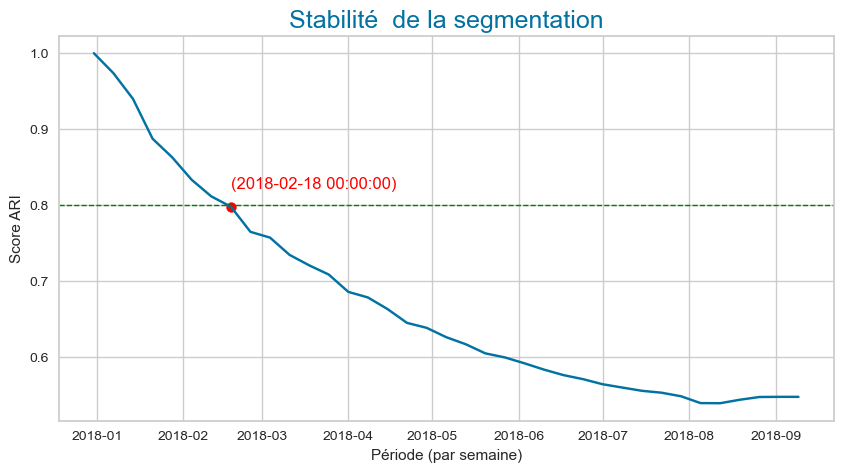

In [34]:
# plot ARI Score
fig, ax = plt.subplots(figsize=(10,5))

sns.lineplot(data=df_recap_, x="Date_Ref", y="ARI")
plt.axhline(y=0.8, linestyle="--", 
            color="green",
            xmax=1,
            linewidth=1)

plt.xlabel("Période (par semaine)")
plt.ylabel("Score ARI")
plt.title("Stabilité  de la segmentation",
          fontsize=18,
          color="b")

df_recap_['diff'] = df_recap_['ARI'] - 0.8
msk = df_recap_['diff'] < 0
closest_point_index = df_recap_.loc[msk].index[0]

# x et y plus proche de 0.8
closest_x = df_recap_.loc[closest_point_index, "Date_Ref"]
closest_y = df_recap_.loc[closest_point_index, "ARI"]
days_to_re_segment = df_recap_.loc[closest_point_index, "nombre_de_jours"]

# plot point plus proche de 0.8
plt.scatter(closest_x, closest_y, marker="o", color="red", s=50)
plt.text(closest_x, closest_y+0.02, f"({closest_x})", 
         ha="left", va="bottom", fontsize=12, color="red")

print('--' * 20)
print(f'date de rupture: {closest_x}')
print(f'ARI de rupture: {closest_y}')
print(f'Nombre de jours avant réinitialisation: {days_to_re_segment} Jours')
print('--' * 20)
plt.savefig("figures/simulation/Stabilité_une_semaine.png", transparent=True, bbox_inches='tight', dpi=300)
plt.show()


In [35]:
# ars = []
# ref_date = []
# nombre_week = []
# for i in range(len(datetime_refs)-1):
#     ref1 = datetime_refs[i]
#     ref2 = datetime_refs[i+1]
    
#     ref_df1 = test[test['datetime_ref'] == ref1]
#     true_labels = ref_df1['cluster'].values
    
#     ref_df2 = test[test['datetime_ref'] == ref2]
#     ref_df2 = ref_df2[ref_df2.index.isin(ref_df1.index)]
#     predicted_labels = ref_df2['cluster'].values
#     numb_week = datetime_refs[i] - start_date
#     ars.append(adjusted_rand_score(true_labels, predicted_labels))
#     ref_date.append(ref2)
#     nombre_week.append(numb_week)
    
# df_recap = pd.DataFrame({
#     "Date_Ref":ref_date,
#     "ARI":ars,
#     "Nombre_week":nombre_week
       
# }).set_index("Date_Ref")
# df_recap

# Simulation par 2 semaine

In [36]:
col_date = 'order_purchase_timestamp'
id_ = 'customer_unique_id'
price_col = 'payment_value'

# Dates de ref pour le calcule du df RFM (plus) Reviews
start_date = dt.datetime(2017, 12,31)
end_date = dt.datetime(2018, 9, 10)
datetime_refs = [start_date]

while datetime_refs[-1] < end_date:
    datetime_refs.append(datetime_refs[-1] + relativedelta(weeks=2))

df = df_generator_k_means(customer_df=cleaned_customers_orders_payments, 
                         col_date=col_date, 
                         datetime_refs=datetime_refs, 
                         id_=id_, 
                         price_col=price_col,
                        n_clusters = 5)




In [37]:
df.head()

,customer_unique_id,recency,frequency,monetary,mean_reviews_scores,datetime_ref,cluster
0,0000f46a3911fa3c0805444483337064,296,1,86.22,3.0,2017-12-31,1
1,0000f6ccb0745a6a4b88665a16c9f078,80,1,43.62,4.0,2017-12-31,2
2,0004aac84e0df4da2b147fca70cf8255,47,1,196.89,5.0,2017-12-31,2
3,0005e1862207bf6ccc02e4228effd9a0,302,1,150.12,4.0,2017-12-31,1
4,0006fdc98a402fceb4eb0ee528f6a8d4,166,1,29.00,3.0,2017-12-31,0


In [38]:
# transformed_geolocation_dataset
path = "./data/simulation/"
filename = "simulation_segments_per_two_weeks.csv"
columns_to_save = list(df.columns)

# Save
save_transformed_df(df, path, filename, columns_to_save)

In [39]:
df["datetime_ref"] = pd.to_datetime(df["datetime_ref"])

In [40]:
df['cluster'].unique()

array([1, 2, 0, 4, 3])

In [41]:
start_date

datetime.datetime(2017, 12, 31, 0, 0)

In [42]:
msk = df['frequency'] > 1
test = df[msk]

In [43]:
test

,customer_unique_id,recency,frequency,monetary,mean_reviews_scores,datetime_ref,cluster
9,000de6019bb59f34c099a907c151d855,136,2,514.88,2.0,2017-12-31,0
11,001147e649a7b1afd577e873841632dd,122,2,424.32,4.0,2017-12-31,2
18,001926cef41060fae572e2e7b30bd2a4,136,2,182.42,4.0,2017-12-31,2
25,00293787e2aec37a9c253b63fdfe2049,65,2,515.74,3.0,2017-12-31,0
27,002ae492472e45ad6ebeb7a625409392,84,2,437.32,3.0,2017-12-31,0
...,...,...,...,...,...,...,...
1444142,ffe96201d466b0e0dc8139850be29d5d,69,2,192.84,5.0,2018-09-23,1
1444158,fff22793223fe80c97a8fd02ac5c6295,89,3,267.57,5.0,2018-09-23,2
1444162,fff5eb4918b2bf4b2da476788d42051c,83,6,17069.76,5.0,2018-09-23,4
1444164,fff7219c86179ca6441b8f37823ba3d3,270,2,531.60,4.0,2018-09-23,1


In [44]:
test = test.set_index('customer_unique_id')

In [45]:
range(len(datetime_refs)-1)

range(0, 19)

In [46]:
msk  = test['datetime_ref'] == start_date
initial_kmeans_df = test[msk]

In [47]:
initial_labels = initial_kmeans_df['cluster'].values

In [48]:

ARI_scores = []
date_de_ref = []
nombre_week = []

for i in range(len(datetime_refs)-1):
    date_ref_suivante = datetime_refs[i]
    ref_df2 = test[test['datetime_ref'] == date_ref_suivante]
    ref_df2 = ref_df2[ref_df2.index.isin(initial_kmeans_df.index)]
    predicted_labels = ref_df2['cluster'].values
    
    ARI_scores.append(adjusted_rand_score(initial_labels, predicted_labels))
    date_de_ref.append(date_ref_suivante)
    numb_week = (datetime_refs[i] - start_date).days
    nombre_week.append(numb_week)
    
df_recap_ = pd.DataFrame({
    "Date_Ref":date_de_ref,
    "ARI":ARI_scores,
    "nombre_de_jours":nombre_week
       
})
df_recap_

,Date_Ref,ARI,nombre_de_jours
0,2017-12-31,1.000000,0
1,2018-01-14,0.939817,14
2,2018-01-28,0.862997,28
3,2018-02-11,0.811564,42
4,2018-02-25,0.764895,56
5,2018-03-11,0.734560,70
6,2018-03-25,0.708728,84
7,2018-04-08,0.678575,98
8,2018-04-22,0.645075,112
9,2018-05-06,0.626304,126


## Stabilité par 2 semaines

----------------------------------------
date de rupture: 2018-02-25 00:00:00
ARI de rupture: 0.7648953542452375
Nombre de jours avant réinitialisation: 56 Jours
----------------------------------------


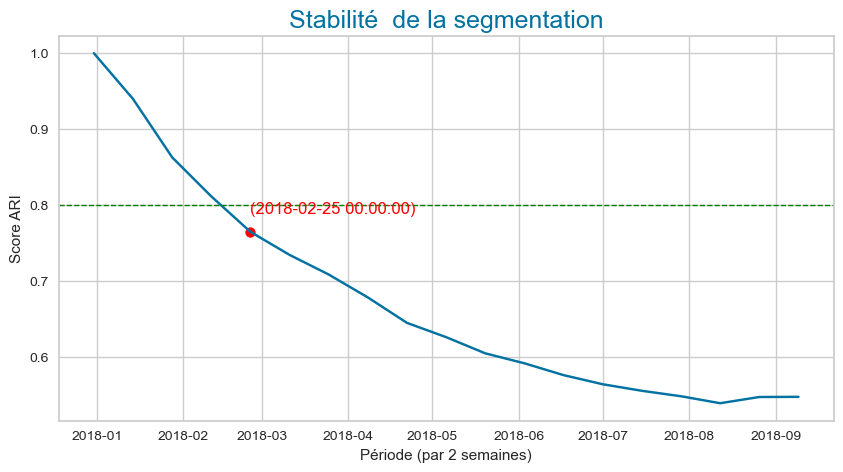

In [49]:
# plot ARI Score
fig, ax = plt.subplots(figsize=(10,5))

sns.lineplot(data=df_recap_, x="Date_Ref", y="ARI")
plt.axhline(y=0.8, linestyle="--", 
            color="green",
            xmax=1,
            linewidth=1)

plt.xlabel("Période (par 2 semaines)")
plt.ylabel("Score ARI")
plt.title("Stabilité  de la segmentation",
          fontsize=18,
          color="b")

df_recap_['diff'] = df_recap_['ARI'] - 0.8
msk = df_recap_['diff'] < 0
closest_point_index = df_recap_.loc[msk].index[0]

# x et y plus proche de 0.8
closest_x = df_recap_.loc[closest_point_index, "Date_Ref"]
closest_y = df_recap_.loc[closest_point_index, "ARI"]
days_to_re_segment = df_recap_.loc[closest_point_index, "nombre_de_jours"]

# plot point plus proche de 0.8
plt.scatter(closest_x, closest_y, marker="o", color="red", s=50)
plt.text(closest_x, closest_y+0.02, f"({closest_x})", 
         ha="left", va="bottom", fontsize=12, color="red")

print('--' * 20)
print(f'date de rupture: {closest_x}')
print(f'ARI de rupture: {closest_y}')
print(f'Nombre de jours avant réinitialisation: {days_to_re_segment} Jours')
print('--' * 20)
plt.savefig("figures/simulation/Stabilité_deux_semaine.png", transparent=True, bbox_inches='tight', dpi=300)
plt.show()


# Simulation 3 semaines

In [50]:
col_date = 'order_purchase_timestamp'
id_ = 'customer_unique_id'
price_col = 'payment_value'

# Dates de ref pour le calcule du df RFM (plus) Reviews
start_date = dt.datetime(2017, 12,31)
end_date = dt.datetime(2018, 9, 10)
datetime_refs = [start_date]

while datetime_refs[-1] < end_date:
    datetime_refs.append(datetime_refs[-1] + relativedelta(weeks=3))

df = df_generator_k_means(customer_df=cleaned_customers_orders_payments, 
                         col_date=col_date, 
                         datetime_refs=datetime_refs, 
                         id_=id_, 
                         price_col=price_col,
                        n_clusters = 5)




In [51]:
df.head()

,customer_unique_id,recency,frequency,monetary,mean_reviews_scores,datetime_ref,cluster
0,0000f46a3911fa3c0805444483337064,296,1,86.22,3.0,2017-12-31,1
1,0000f6ccb0745a6a4b88665a16c9f078,80,1,43.62,4.0,2017-12-31,2
2,0004aac84e0df4da2b147fca70cf8255,47,1,196.89,5.0,2017-12-31,2
3,0005e1862207bf6ccc02e4228effd9a0,302,1,150.12,4.0,2017-12-31,1
4,0006fdc98a402fceb4eb0ee528f6a8d4,166,1,29.00,3.0,2017-12-31,0


In [52]:
# transformed_geolocation_dataset
path = "./data/cleaned/"
filename = "simulation_segments_per_three_weeks.csv"
columns_to_save = list(df.columns)

# Save
save_transformed_df(df, path, filename, columns_to_save)

In [53]:
df["datetime_ref"] = pd.to_datetime(df["datetime_ref"])

In [54]:
df['cluster'].unique()

array([1, 2, 0, 4, 3])

In [55]:
start_date

datetime.datetime(2017, 12, 31, 0, 0)

In [56]:
msk = df['frequency'] > 1
test = df[msk]

In [57]:
test

,customer_unique_id,recency,frequency,monetary,mean_reviews_scores,datetime_ref,cluster
9,000de6019bb59f34c099a907c151d855,136,2,514.88,2.0,2017-12-31,0
11,001147e649a7b1afd577e873841632dd,122,2,424.32,4.0,2017-12-31,2
18,001926cef41060fae572e2e7b30bd2a4,136,2,182.42,4.0,2017-12-31,2
25,00293787e2aec37a9c253b63fdfe2049,65,2,515.74,3.0,2017-12-31,0
27,002ae492472e45ad6ebeb7a625409392,84,2,437.32,3.0,2017-12-31,0
...,...,...,...,...,...,...,...
1017654,ffe96201d466b0e0dc8139850be29d5d,76,2,192.84,5.0,2018-09-30,1
1017670,fff22793223fe80c97a8fd02ac5c6295,96,3,267.57,5.0,2018-09-30,2
1017674,fff5eb4918b2bf4b2da476788d42051c,90,6,17069.76,5.0,2018-09-30,4
1017676,fff7219c86179ca6441b8f37823ba3d3,277,2,531.60,4.0,2018-09-30,1


In [58]:
test = test.set_index('customer_unique_id')

In [59]:
range(len(datetime_refs)-1)

range(0, 13)

In [60]:
msk  = test['datetime_ref'] == start_date
initial_kmeans_df = test[msk]

In [61]:
initial_labels = initial_kmeans_df['cluster'].values

In [62]:

ARI_scores = []
date_de_ref = []
nombre_week = []

for i in range(len(datetime_refs)-1):
    date_ref_suivante = datetime_refs[i]
    ref_df2 = test[test['datetime_ref'] == date_ref_suivante]
    ref_df2 = ref_df2[ref_df2.index.isin(initial_kmeans_df.index)]
    predicted_labels = ref_df2['cluster'].values
    
    ARI_scores.append(adjusted_rand_score(initial_labels, predicted_labels))
    date_de_ref.append(date_ref_suivante)
    numb_week = (datetime_refs[i] - start_date).days
    nombre_week.append(numb_week)
    
df_recap_ = pd.DataFrame({
    "Date_Ref":date_de_ref,
    "ARI":ARI_scores,
    "nombre_de_jours":nombre_week
       
})
df_recap_

,Date_Ref,ARI,nombre_de_jours
0,2017-12-31,1.000000,0
1,2018-01-21,0.887457,21
2,2018-02-11,0.811564,42
3,2018-03-04,0.757335,63
4,2018-03-25,0.708728,84
5,2018-04-15,0.663344,105
6,2018-05-06,0.626304,126
7,2018-05-27,0.599637,147
8,2018-06-17,0.576316,168
9,2018-07-08,0.559977,189


## Stabilité par 3 semaines

----------------------------------------
date de rupture: 2018-03-04 00:00:00
ARI de rupture: 0.7573350625168468
Nombre de jours avant réinitialisation: 63 Jours
----------------------------------------


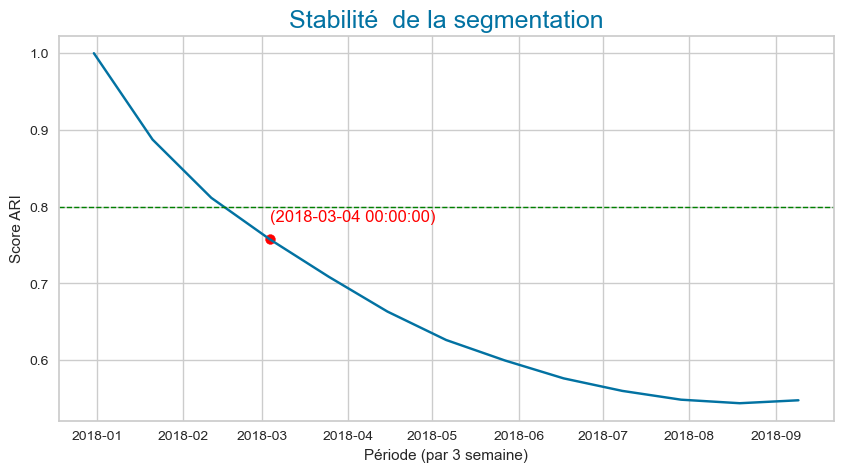

In [63]:
# plot ARI Score
fig, ax = plt.subplots(figsize=(10,5))

sns.lineplot(data=df_recap_, x="Date_Ref", y="ARI")
plt.axhline(y=0.8, linestyle="--", 
            color="green",
            xmax=1,
            linewidth=1)

plt.xlabel("Période (par 3 semaine)")
plt.ylabel("Score ARI")
plt.title("Stabilité  de la segmentation",
          fontsize=18,
          color="b")

df_recap_['diff'] = df_recap_['ARI'] - 0.8
msk = df_recap_['diff'] < 0
closest_point_index = df_recap_.loc[msk].index[0]

# x et y plus proche de 0.8
closest_x = df_recap_.loc[closest_point_index, "Date_Ref"]
closest_y = df_recap_.loc[closest_point_index, "ARI"]
days_to_re_segment = df_recap_.loc[closest_point_index, "nombre_de_jours"]

# plot point plus proche de 0.8
plt.scatter(closest_x, closest_y, marker="o", color="red", s=50)
plt.text(closest_x, closest_y+0.02, f"({closest_x})", 
         ha="left", va="bottom", fontsize=12, color="red")

print('--' * 20)
print(f'date de rupture: {closest_x}')
print(f'ARI de rupture: {closest_y}')
print(f'Nombre de jours avant réinitialisation: {days_to_re_segment} Jours')
print('--' * 20)
plt.savefig("figures/simulation/Stabilité_trois_semaine.png", transparent=True, bbox_inches='tight', dpi=300)
plt.show()


# Simulation 1 mois

In [64]:
col_date = 'order_purchase_timestamp'
id_ = 'customer_unique_id'
price_col = 'payment_value'

# Dates de ref pour le calcule du df RFM (plus) Reviews
start_date = dt.datetime(2017, 12,31)
end_date = dt.datetime(2018, 9, 10)
datetime_refs = [start_date]

while datetime_refs[-1] < end_date:
    datetime_refs.append(datetime_refs[-1] + relativedelta(months=1))

df = df_generator_k_means(customer_df=cleaned_customers_orders_payments, 
                         col_date=col_date, 
                         datetime_refs=datetime_refs, 
                         id_=id_, 
                         price_col=price_col,
                        n_clusters = 5)




In [65]:
df.head()

,customer_unique_id,recency,frequency,monetary,mean_reviews_scores,datetime_ref,cluster
0,0000f46a3911fa3c0805444483337064,296,1,86.22,3.0,2017-12-31,1
1,0000f6ccb0745a6a4b88665a16c9f078,80,1,43.62,4.0,2017-12-31,2
2,0004aac84e0df4da2b147fca70cf8255,47,1,196.89,5.0,2017-12-31,2
3,0005e1862207bf6ccc02e4228effd9a0,302,1,150.12,4.0,2017-12-31,1
4,0006fdc98a402fceb4eb0ee528f6a8d4,166,1,29.00,3.0,2017-12-31,0


In [66]:
datetime_refs

[datetime.datetime(2017, 12, 31, 0, 0),
 datetime.datetime(2018, 1, 31, 0, 0),
 datetime.datetime(2018, 2, 28, 0, 0),
 datetime.datetime(2018, 3, 28, 0, 0),
 datetime.datetime(2018, 4, 28, 0, 0),
 datetime.datetime(2018, 5, 28, 0, 0),
 datetime.datetime(2018, 6, 28, 0, 0),
 datetime.datetime(2018, 7, 28, 0, 0),
 datetime.datetime(2018, 8, 28, 0, 0),
 datetime.datetime(2018, 9, 28, 0, 0)]

In [67]:
# transformed_geolocation_dataset
path = "./data/simulation/"
filename = "simulation_segments_per_month.csv"
columns_to_save = list(df.columns)

# Save
save_transformed_df(df, path, filename, columns_to_save)

In [68]:
df["datetime_ref"] = pd.to_datetime(df["datetime_ref"])

In [69]:
df['cluster'].unique()

array([1, 2, 0, 4, 3])

In [70]:
start_date

datetime.datetime(2017, 12, 31, 0, 0)

In [71]:
msk = df['frequency'] > 1
test = df[msk]

In [72]:
test

,customer_unique_id,recency,frequency,monetary,mean_reviews_scores,datetime_ref,cluster
9,000de6019bb59f34c099a907c151d855,136,2,514.88,2.0,2017-12-31,0
11,001147e649a7b1afd577e873841632dd,122,2,424.32,4.0,2017-12-31,2
18,001926cef41060fae572e2e7b30bd2a4,136,2,182.42,4.0,2017-12-31,2
25,00293787e2aec37a9c253b63fdfe2049,65,2,515.74,3.0,2017-12-31,0
27,002ae492472e45ad6ebeb7a625409392,84,2,437.32,3.0,2017-12-31,0
...,...,...,...,...,...,...,...
721805,ffe96201d466b0e0dc8139850be29d5d,74,2,192.84,5.0,2018-09-28,1
721821,fff22793223fe80c97a8fd02ac5c6295,94,3,267.57,5.0,2018-09-28,2
721825,fff5eb4918b2bf4b2da476788d42051c,88,6,17069.76,5.0,2018-09-28,4
721827,fff7219c86179ca6441b8f37823ba3d3,275,2,531.60,4.0,2018-09-28,1


In [73]:
test = test.set_index('customer_unique_id')

In [74]:
range(len(datetime_refs)-1)

range(0, 9)

In [75]:
msk  = test['datetime_ref'] == start_date
initial_kmeans_df = test[msk]

In [76]:
initial_labels = initial_kmeans_df['cluster'].values

In [77]:

ARI_scores = []
date_de_ref = []
nombre_week = []

for i in range(len(datetime_refs)-1):
    date_ref_suivante = datetime_refs[i]
    ref_df2 = test[test['datetime_ref'] == date_ref_suivante]
    ref_df2 = ref_df2[ref_df2.index.isin(initial_kmeans_df.index)]
    predicted_labels = ref_df2['cluster'].values
    
    ARI_scores.append(adjusted_rand_score(initial_labels, predicted_labels))
    date_de_ref.append(date_ref_suivante)
    numb_week = (datetime_refs[i] - start_date).days
    nombre_week.append(numb_week)
    
df_recap_ = pd.DataFrame({
    "Date_Ref":date_de_ref,
    "ARI":ARI_scores,
    "nombre_de_jours":nombre_week
       
})
df_recap_

,Date_Ref,ARI,nombre_de_jours
0,2017-12-31,1.000000,0
1,2018-01-31,0.849947,31
2,2018-02-28,0.779759,59
3,2018-03-28,0.702810,87
4,2018-04-28,0.638910,118
5,2018-05-28,0.601491,148
6,2018-06-28,0.567148,179
7,2018-07-28,0.548477,209
8,2018-08-28,0.548054,240


## Stabilité par 1 mois

----------------------------------------
date de rupture: 2018-02-28 00:00:00
ARI de rupture: 0.7797591614127937
Nombre de jours avant réinitialisation: 59 Jours
----------------------------------------


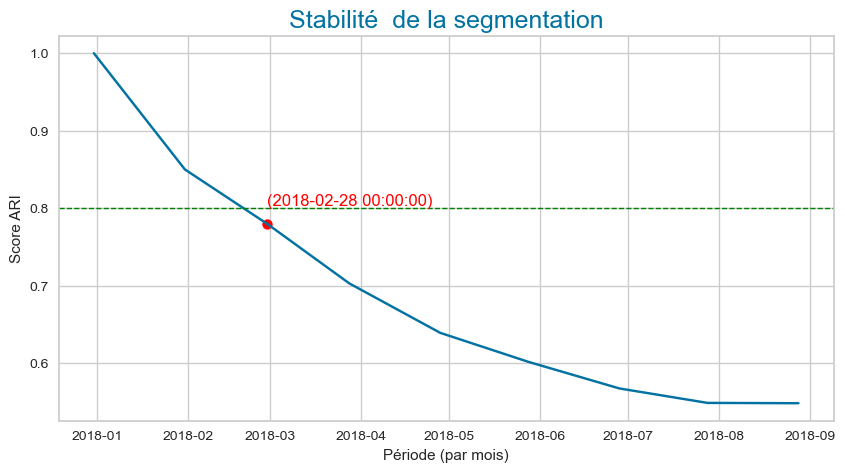

In [78]:
# plot ARI Score
fig, ax = plt.subplots(figsize=(10,5))

sns.lineplot(data=df_recap_, x="Date_Ref", y="ARI")
plt.axhline(y=0.8, linestyle="--", 
            color="green",
            xmax=1,
            linewidth=1)

plt.xlabel("Période (par mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité  de la segmentation",
          fontsize=18,
          color="b")

df_recap_['diff'] = df_recap_['ARI'] - 0.8
msk = df_recap_['diff'] < 0
closest_point_index = df_recap_.loc[msk].index[0]

# x et y plus proche de 0.8
closest_x = df_recap_.loc[closest_point_index, "Date_Ref"]
closest_y = df_recap_.loc[closest_point_index, "ARI"]
days_to_re_segment = df_recap_.loc[closest_point_index, "nombre_de_jours"]

# plot point plus proche de 0.8
plt.scatter(closest_x, closest_y, marker="o", color="red", s=50)
plt.text(closest_x, closest_y+0.02, f"({closest_x})", 
         ha="left", va="bottom", fontsize=12, color="red")

print('--' * 20)
print(f'date de rupture: {closest_x}')
print(f'ARI de rupture: {closest_y}')
print(f'Nombre de jours avant réinitialisation: {days_to_re_segment} Jours')
print('--' * 20)
plt.savefig("figures/simulation/Stabilité_un_mois.png", transparent=True, bbox_inches='tight', dpi=300)
plt.show()


# Simulation 2 mois

In [79]:
col_date = 'order_purchase_timestamp'
id_ = 'customer_unique_id'
price_col = 'payment_value'

# Dates de ref pour le calcule du df RFM (plus) Reviews
start_date = dt.datetime(2017, 12,31)
end_date = dt.datetime(2018, 9, 10)
datetime_refs = [start_date]

while datetime_refs[-1] < end_date:
    datetime_refs.append(datetime_refs[-1] + relativedelta(months=2))

df = df_generator_k_means(customer_df=cleaned_customers_orders_payments, 
                         col_date=col_date, 
                         datetime_refs=datetime_refs, 
                         id_=id_, 
                         price_col=price_col,
                        n_clusters = 5)




In [80]:
df.head()

,customer_unique_id,recency,frequency,monetary,mean_reviews_scores,datetime_ref,cluster
0,0000f46a3911fa3c0805444483337064,296,1,86.22,3.0,2017-12-31,1
1,0000f6ccb0745a6a4b88665a16c9f078,80,1,43.62,4.0,2017-12-31,2
2,0004aac84e0df4da2b147fca70cf8255,47,1,196.89,5.0,2017-12-31,2
3,0005e1862207bf6ccc02e4228effd9a0,302,1,150.12,4.0,2017-12-31,1
4,0006fdc98a402fceb4eb0ee528f6a8d4,166,1,29.00,3.0,2017-12-31,0


In [81]:
datetime_refs

[datetime.datetime(2017, 12, 31, 0, 0),
 datetime.datetime(2018, 2, 28, 0, 0),
 datetime.datetime(2018, 4, 28, 0, 0),
 datetime.datetime(2018, 6, 28, 0, 0),
 datetime.datetime(2018, 8, 28, 0, 0),
 datetime.datetime(2018, 10, 28, 0, 0)]

In [82]:
# transformed_geolocation_dataset
path = "./data/simulation/"
filename = "simulation_segments_per_two_months.csv"
columns_to_save = list(df.columns)

# Save
save_transformed_df(df, path, filename, columns_to_save)

In [83]:
df["datetime_ref"] = pd.to_datetime(df["datetime_ref"])

In [84]:
df['cluster'].unique()

array([1, 2, 0, 4, 3])

In [85]:
start_date

datetime.datetime(2017, 12, 31, 0, 0)

In [86]:
msk = df['frequency'] > 1
test = df[msk]

In [87]:
test

,customer_unique_id,recency,frequency,monetary,mean_reviews_scores,datetime_ref,cluster
9,000de6019bb59f34c099a907c151d855,136,2,514.88,2.0,2017-12-31,0
11,001147e649a7b1afd577e873841632dd,122,2,424.32,4.0,2017-12-31,2
18,001926cef41060fae572e2e7b30bd2a4,136,2,182.42,4.0,2017-12-31,2
25,00293787e2aec37a9c253b63fdfe2049,65,2,515.74,3.0,2017-12-31,0
27,002ae492472e45ad6ebeb7a625409392,84,2,437.32,3.0,2017-12-31,0
...,...,...,...,...,...,...,...
443482,ffe96201d466b0e0dc8139850be29d5d,104,2,192.84,5.0,2018-10-28,1
443498,fff22793223fe80c97a8fd02ac5c6295,124,3,267.57,5.0,2018-10-28,2
443502,fff5eb4918b2bf4b2da476788d42051c,118,6,17069.76,5.0,2018-10-28,4
443504,fff7219c86179ca6441b8f37823ba3d3,305,2,531.60,4.0,2018-10-28,1


In [88]:
test = test.set_index('customer_unique_id')

In [89]:
range(len(datetime_refs)-1)

range(0, 5)

In [90]:
msk  = test['datetime_ref'] == start_date
initial_kmeans_df = test[msk]

In [91]:
initial_labels = initial_kmeans_df['cluster'].values

In [92]:

ARI_scores = []
date_de_ref = []
nombre_week = []

for i in range(len(datetime_refs)-1):
    date_ref_suivante = datetime_refs[i]
    ref_df2 = test[test['datetime_ref'] == date_ref_suivante]
    ref_df2 = ref_df2[ref_df2.index.isin(initial_kmeans_df.index)]
    predicted_labels = ref_df2['cluster'].values
    
    ARI_scores.append(adjusted_rand_score(initial_labels, predicted_labels))
    date_de_ref.append(date_ref_suivante)
    numb_week = (datetime_refs[i] - start_date).days
    nombre_week.append(numb_week)
    
df_recap_ = pd.DataFrame({
    "Date_Ref":date_de_ref,
    "ARI":ARI_scores,
    "nombre_de_jours":nombre_week
       
})
df_recap_

,Date_Ref,ARI,nombre_de_jours
0,2017-12-31,1.000000,0
1,2018-02-28,0.779759,59
2,2018-04-28,0.638910,118
3,2018-06-28,0.567148,179
4,2018-08-28,0.548054,240


## Stabilité par 2 mois

----------------------------------------
date de rupture: 2018-02-28 00:00:00
ARI de rupture: 0.7797591614127937
Nombre de jours avant réinitialisation: 59 Jours
----------------------------------------


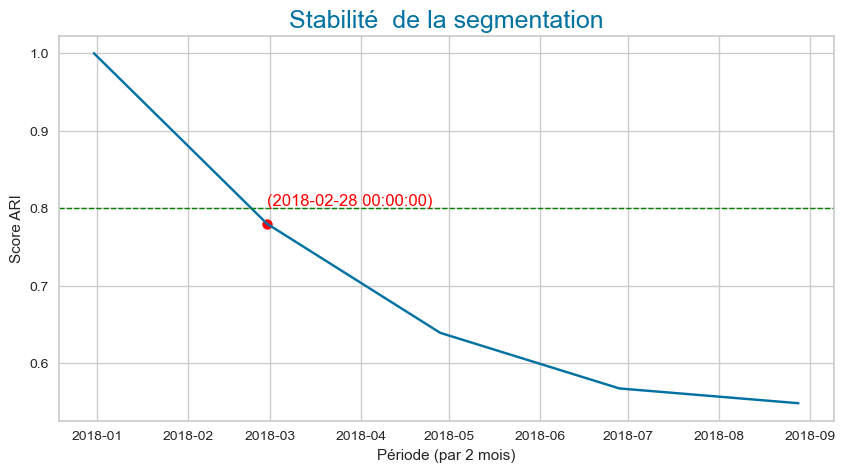

In [93]:
# plot ARI Score
fig, ax = plt.subplots(figsize=(10,5))

sns.lineplot(data=df_recap_, x="Date_Ref", y="ARI")
plt.axhline(y=0.8, linestyle="--", 
            color="green",
            xmax=1,
            linewidth=1)

plt.xlabel("Période (par 2 mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité  de la segmentation",
          fontsize=18,
          color="b")

df_recap_['diff'] = df_recap_['ARI'] - 0.8
msk = df_recap_['diff'] < 0
closest_point_index = df_recap_.loc[msk].index[0]

# x et y plus proche de 0.8
closest_x = df_recap_.loc[closest_point_index, "Date_Ref"]
closest_y = df_recap_.loc[closest_point_index, "ARI"]
days_to_re_segment = df_recap_.loc[closest_point_index, "nombre_de_jours"]

# plot point plus proche de 0.8
plt.scatter(closest_x, closest_y, marker="o", color="red", s=50)
plt.text(closest_x, closest_y+0.02, f"({closest_x})", 
         ha="left", va="bottom", fontsize=12, color="red")

print('--' * 20)
print(f'date de rupture: {closest_x}')
print(f'ARI de rupture: {closest_y}')
print(f'Nombre de jours avant réinitialisation: {days_to_re_segment} Jours')
print('--' * 20)
plt.savefig("figures/Stabilité.png", transparent=False, bbox_inches='tight', dpi=200)
plt.show()


# Simulation 3 mois

In [94]:
col_date = 'order_purchase_timestamp'
id_ = 'customer_unique_id'
price_col = 'payment_value'

# Dates de ref pour le calcule du df RFM (plus) Reviews
start_date = dt.datetime(2017, 12,31)
end_date = dt.datetime(2018, 9, 10)
datetime_refs = [start_date]

while datetime_refs[-1] < end_date:
    datetime_refs.append(datetime_refs[-1] + relativedelta(months=3))

df = df_generator_k_means(customer_df=cleaned_customers_orders_payments, 
                         col_date=col_date, 
                         datetime_refs=datetime_refs, 
                         id_=id_, 
                         price_col=price_col,
                        n_clusters = 5)




In [95]:
df.head()

,customer_unique_id,recency,frequency,monetary,mean_reviews_scores,datetime_ref,cluster
0,0000f46a3911fa3c0805444483337064,296,1,86.22,3.0,2017-12-31,1
1,0000f6ccb0745a6a4b88665a16c9f078,80,1,43.62,4.0,2017-12-31,2
2,0004aac84e0df4da2b147fca70cf8255,47,1,196.89,5.0,2017-12-31,2
3,0005e1862207bf6ccc02e4228effd9a0,302,1,150.12,4.0,2017-12-31,1
4,0006fdc98a402fceb4eb0ee528f6a8d4,166,1,29.00,3.0,2017-12-31,0


In [96]:
datetime_refs

[datetime.datetime(2017, 12, 31, 0, 0),
 datetime.datetime(2018, 3, 31, 0, 0),
 datetime.datetime(2018, 6, 30, 0, 0),
 datetime.datetime(2018, 9, 30, 0, 0)]

In [97]:
# transformed_geolocation_dataset
path = "./data/simulation/"
filename = "simulation_segments_per_three_months.csv"
columns_to_save = list(df.columns)

# Save
save_transformed_df(df, path, filename, columns_to_save)

In [98]:
df["datetime_ref"] = pd.to_datetime(df["datetime_ref"])

In [99]:
df['cluster'].unique()

array([1, 2, 0, 4, 3])

In [100]:
start_date

datetime.datetime(2017, 12, 31, 0, 0)

In [101]:
msk = df['frequency'] > 1
test = df[msk]

In [102]:
test

,customer_unique_id,recency,frequency,monetary,mean_reviews_scores,datetime_ref,cluster
9,000de6019bb59f34c099a907c151d855,136,2,514.88,2.0,2017-12-31,0
11,001147e649a7b1afd577e873841632dd,122,2,424.32,4.0,2017-12-31,2
18,001926cef41060fae572e2e7b30bd2a4,136,2,182.42,4.0,2017-12-31,2
25,00293787e2aec37a9c253b63fdfe2049,65,2,515.74,3.0,2017-12-31,0
27,002ae492472e45ad6ebeb7a625409392,84,2,437.32,3.0,2017-12-31,0
...,...,...,...,...,...,...,...
285576,ffe96201d466b0e0dc8139850be29d5d,76,2,192.84,5.0,2018-09-30,1
285592,fff22793223fe80c97a8fd02ac5c6295,96,3,267.57,5.0,2018-09-30,2
285596,fff5eb4918b2bf4b2da476788d42051c,90,6,17069.76,5.0,2018-09-30,4
285598,fff7219c86179ca6441b8f37823ba3d3,277,2,531.60,4.0,2018-09-30,1


In [103]:
test = test.set_index('customer_unique_id')

In [104]:
range(len(datetime_refs)-1)

range(0, 3)

In [105]:
msk  = test['datetime_ref'] == start_date
initial_kmeans_df = test[msk]

In [106]:
initial_labels = initial_kmeans_df['cluster'].values

In [107]:

ARI_scores = []
date_de_ref = []
nombre_week = []

for i in range(len(datetime_refs)-1):
    date_ref_suivante = datetime_refs[i]
    ref_df2 = test[test['datetime_ref'] == date_ref_suivante]
    ref_df2 = ref_df2[ref_df2.index.isin(initial_kmeans_df.index)]
    predicted_labels = ref_df2['cluster'].values
    
    ARI_scores.append(adjusted_rand_score(initial_labels, predicted_labels))
    date_de_ref.append(date_ref_suivante)
    numb_week = (datetime_refs[i] - start_date).days
    nombre_week.append(numb_week)
    
df_recap_ = pd.DataFrame({
    "Date_Ref":date_de_ref,
    "ARI":ARI_scores,
    "nombre_de_jours":nombre_week
       
})
df_recap_

,Date_Ref,ARI,nombre_de_jours
0,2017-12-31,1.000000,0
1,2018-03-31,0.686239,90
2,2018-06-30,0.564874,181


## Stabilité par 3 mois

----------------------------------------
date de rupture: 2018-03-31 00:00:00
ARI de rupture: 0.6862394873943024
Nombre de jours avant réinitialisation: 90 Jours
----------------------------------------


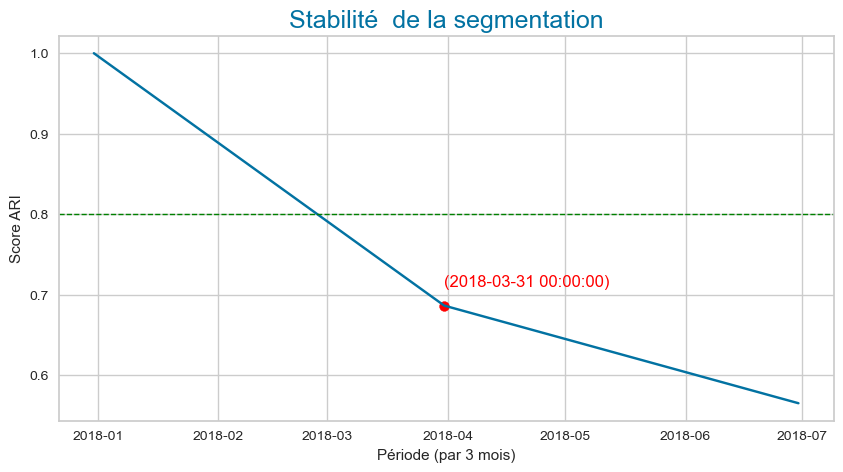

In [108]:
# plot ARI Score
fig, ax = plt.subplots(figsize=(10,5))

sns.lineplot(data=df_recap_, x="Date_Ref", y="ARI")
plt.axhline(y=0.8, linestyle="--", 
            color="green",
            xmax=1,
            linewidth=1)

plt.xlabel("Période (par 3 mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité  de la segmentation",
          fontsize=18,
          color="b")

df_recap_['diff'] = df_recap_['ARI'] - 0.8
msk = df_recap_['diff'] < 0
closest_point_index = df_recap_.loc[msk].index[0]

# x et y plus proche de 0.8
closest_x = df_recap_.loc[closest_point_index, "Date_Ref"]
closest_y = df_recap_.loc[closest_point_index, "ARI"]
days_to_re_segment = df_recap_.loc[closest_point_index, "nombre_de_jours"]

# plot point plus proche de 0.8
plt.scatter(closest_x, closest_y, marker="o", color="red", s=50)
plt.text(closest_x, closest_y+0.02, f"({closest_x})", 
         ha="left", va="bottom", fontsize=12, color="red")

print('--' * 20)
print(f'date de rupture: {closest_x}')
print(f'ARI de rupture: {closest_y}')
print(f'Nombre de jours avant réinitialisation: {days_to_re_segment} Jours')
print('--' * 20)
plt.savefig("figures/Stabilité.png", transparent=False, bbox_inches='tight', dpi=200)
plt.show()
